## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.model_selection import train_test_split
np.random.seed(2019)
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

In [2]:
# your code here
Data1['LogTrafficCount'] = np.log(Data1['AvgDailyTrafficCount'])
Data1['NormalizedTrafficCount'] = Data1['LogTrafficCount'] - Data1['LogTrafficCount'].mean()

In [3]:
x_obs = Data1[['Longitude', 'Latitude']]
y_obs = Data1['NormalizedTrafficCount']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x_obs, y_obs, test_size=0.2, random_state=2019)

In [5]:
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=2019)
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=2019)

2) The log marginal likelihood of the training data. (5 pts)

In [6]:
print("The log marginal likelihood of the training data is %f"%gp.log_marginal_likelihood_value_)

The log marginal likelihood of the training data is -1100.103217


3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

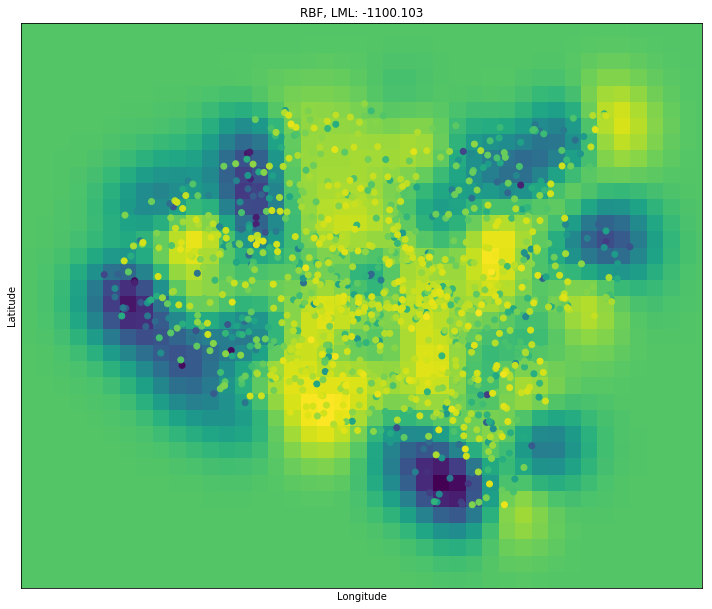

In [7]:
# create a mesh to plot in
x_min, x_max = Data1['Longitude'].min() - 0.1, Data1['Longitude'].max() + 0.1
y_min, y_max = Data1['Latitude'].min() - 0.1, Data1['Latitude'].max() + 0.1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(10, 10))
# ax = plt.gca()
# im = ax.imshow(np.arange(100).reshape((10,10)))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(Data1['Longitude'], Data1['Latitude'], c=Data1['NormalizedTrafficCount'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood_value_))

plt.tight_layout()
plt.show()

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

In [8]:
Data1['PredictTrafficCount'] = gp.predict(Data1[['Longitude', 'Latitude']])
std = Data1['PredictTrafficCount'].std()
Data1["Difference"] = (Data1['NormalizedTrafficCount'] - Data1['PredictTrafficCount'])/(2*std)

In [9]:
upper = 0
lower = 0
upper_pro = 0
lower_pro = 0
for i in Data1["Difference"]:
    if i > 1:
        upper += 1
    if i < -1:
        lower += 1
upper_pro = upper/Data1.shape[0]
lower_pro = lower/Data1.shape[0]
print ("Percentage outside of 2 standard deviation is %f"%((upper_pro + lower_pro)*100) + "%.")

Percentage outside of 2 standard deviation is 13.901345%.


5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

In [10]:
def abnormal(df):
    if df["Difference"] > 1:
        return 1
    elif df["Difference"] < -1:
        return -1
    else:
        return 0
Data1["Abnormal"] = Data1.apply(abnormal, axis=1).tolist()

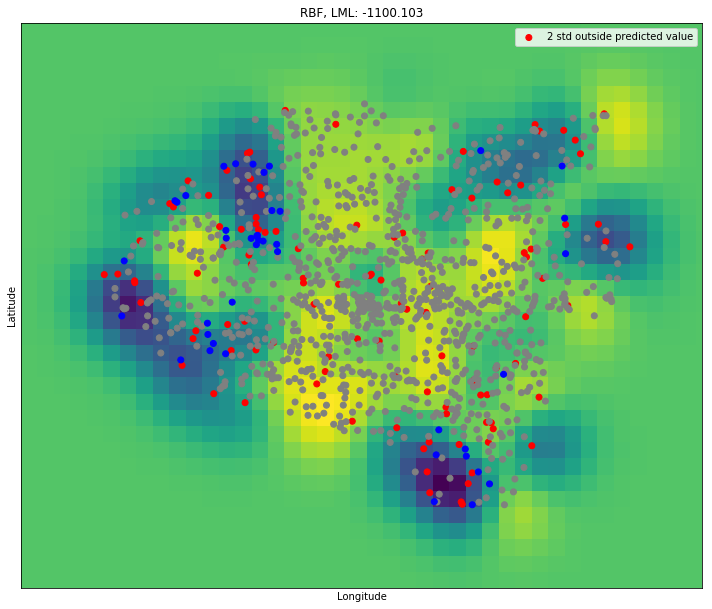

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(Data1['Longitude'], Data1['Latitude'], 
            c=np.array(['grey', 'blue', 'red'])[Data1['Abnormal']], 
            label='2 std outside predicted value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood_value_))
plt.legend()

plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		**Anomaly**

If we using local-based anomoly detection, this point abnormal since it is 10 std outside of the nearest cluster center. But if we using global density-based anomoly detection, then this point would not be consider as abnormal. Since it is actually very close to a dense pack as distance wise.


(35, 2)		**Not Anomaly**

This point is only one std within the cluster center (35,5), and this cluster is less dense than the above cluster. So this point is not abnormal.


(15, 19)	**Anomaly** 

Although this point is only one std within the cluster center (15,20), this cluster only contains 2 points. Points are all highly likely to be marked abnormal in this tiny group.


(10, 11)	**Not Anomaly**


The nearest cluster center is (10,10) with only 1 std and 200 points (most sparse cluster), so this point would not be detected as abnormal.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [12]:
pd.set_option('display.max_columns', 500)

In [13]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate','Teen Birth Rate','\% Uninsured','Preventable Hosp. Rate','\% Dibetics receiving HbA1c','\% Mammography','Graduation Rate','\% Some College','\% Unemployed','\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,15,32,416,35,13,62,84,62,83,56.5,5.9,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,15,39,308,42,17,49,84,66,80,62.3,6.1,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,12,39,632,68,17,61,90,63,81,43.4,10.8,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,14,34,367,48,15,74,84,59,81,48.9,7.1,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,14,19,159,45,18,63,86,61,85,49.1,6.1,24,4.1,28,8.5,219,89,12.7,12,85,59


In [14]:
Data2.shape

(3141, 31)

In [15]:
Data2 = Data2[Data2.iloc[:,:]!="?"].dropna()

/nfshome/pl1840/.conda/envs/myEnv3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [16]:
Data2.shape

(2486, 31)

In [17]:
Data2 = Data2.convert_objects(convert_numeric=True)
Data2.convert_objects(convert_numeric=True).dtypes

/nfshome/pl1840/.conda/envs/myEnv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
/nfshome/pl1840/.conda/envs/myEnv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


County                                    object
'\% Reporting Fair/Poor Health'            int64
'Physically Unhealthy Days Per Month'    float64
'Mentally Unhealthy Days Per Month'      float64
'\% Low birth weight births'               int64
'\% Smokers'                               int64
'\% Obese'                                 int64
'Food Environment Index'                 float64
'\% Physically Inactive'                   int64
'\% With Access To Exercise'               int64
'\% Excessive Drinking'                    int64
'\% Alcohol-Impaired Driving Deaths'       int64
'Chlamydia Rate'                           int64
'Teen Birth Rate'                          int64
'\% Uninsured'                             int64
'Preventable Hosp. Rate'                   int64
'\% Dibetics receiving HbA1c'              int64
'\% Mammography'                           int64
'Graduation Rate'                          int64
'\% Some College'                        float64
'\% Unemployed'     

In [18]:
Data2.dropna(inplace=True)

In [19]:
Data2.isna().sum()

County                                   0
'\% Reporting Fair/Poor Health'          0
'Physically Unhealthy Days Per Month'    0
'Mentally Unhealthy Days Per Month'      0
'\% Low birth weight births'             0
'\% Smokers'                             0
'\% Obese'                               0
'Food Environment Index'                 0
'\% Physically Inactive'                 0
'\% With Access To Exercise'             0
'\% Excessive Drinking'                  0
'\% Alcohol-Impaired Driving Deaths'     0
'Chlamydia Rate'                         0
'Teen Birth Rate'                        0
'\% Uninsured'                           0
'Preventable Hosp. Rate'                 0
'\% Dibetics receiving HbA1c'            0
'\% Mammography'                         0
'Graduation Rate'                        0
'\% Some College'                        0
'\% Unemployed'                          0
'\% Children in Poverty'                 0
'80/20 Income Ratio'                     0
'\% Single-

In [20]:
Data2.set_index("County", inplace=True)

In [21]:
Data2.shape

(2486, 30)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

In [22]:
df = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'",
            "'\% Children in Poverty'","'Average Daily PM2.5'"]]
df.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",19,31,254,4.3,18,12.9
"Baldwin, Alabama",19,27,221,4.5,20,13.1
"Barbour, Alabama",21,41,147,5.3,38,12.6
"Bibb, Alabama",21,40,236,4.3,27,12.9
"Blount, Alabama",19,32,219,4.1,24,12.7


In [23]:
df.describe()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,18.569992,31.022928,267.538616,4.545133,23.844730,11.720072
std,3.646631,4.524278,198.532609,0.695486,8.692791,1.535203
min,7.000000,11.000000,0.000000,2.700000,3.000000,7.200000
25%,16.000000,29.000000,128.000000,4.100000,17.250000,10.600000
50%,18.000000,31.000000,216.000000,4.400000,23.000000,12.000000
75%,21.000000,34.000000,356.750000,4.900000,29.000000,13.000000
max,41.000000,46.000000,1885.000000,8.700000,54.000000,14.900000


In [24]:
df.columns

Index([''\% Smokers'', ''\% Obese'', ''Violent Crime Rate'',
       ''80/20 Income Ratio'', ''\% Children in Poverty'',
       ''Average Daily PM2.5''],
      dtype='object')

In [25]:
for column in df.columns:
    df[column] = pd.qcut(df[column],5,labels=False)

/nfshome/pl1840/.conda/envs/myEnv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
df.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",2,2,2,1,1,3
"Baldwin, Alabama",2,0,2,2,1,3
"Barbour, Alabama",3,4,1,4,4,3
"Bibb, Alabama",3,4,2,1,3,3
"Blount, Alabama",2,2,2,1,2,3


In [27]:
df.describe()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,1.775543,1.847949,1.996380,1.896219,1.907884,1.963797
std,1.473407,1.389892,1.414636,1.440884,1.397599,1.404325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

In [28]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
hc = HillClimbSearch(df, scoring_method=BicScore(df))
best_model = hc.estimate()
print(best_model.edges())

[("'\\% Smokers'", "'\\% Obese'"), ("'\\% Smokers'", "'\\% Children in Poverty'"), ("'80/20 Income Ratio'", "'Violent Crime Rate'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'Average Daily PM2.5'", "'\\% Smokers'")]


(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [29]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel(best_model.edges())
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print (thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

# compute anomalousness of each of the first 500 data records
exmp=df.apply(lambda x: LL(x,model),axis=1)

In [30]:
# 10 most anomalous data records
print (exmp.sort_values().head(5))

County
Montgomery, Virginia          -14.028248
Harrisonburg City, Virginia   -13.929264
La Paz, Arizona               -13.743477
Highlands, Florida            -13.348434
Lafayette, Louisiana          -13.302995
dtype: float64


Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

In [31]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=666)
scors=KM.fit_predict(Data2)

In [32]:
res = pd.DataFrame(KM.transform(Data2), index = Data2.index)

In [33]:
res['Min_Distance'] = res.min(axis=1)

In [34]:
res['Nearest_Center'] = res.idxmin(axis=1)

In [35]:
res.rename(columns = {0:"Cluster1", 1:"Cluster2", 2:"Cluster3"}, inplace=True)

In [36]:
km = res.sort_values('Min_Distance', ascending = False).head(5)

In [37]:
km.reset_index(inplace=True)

In [38]:
km

,County,Cluster1,Cluster2,Cluster3,Min_Distance,Nearest_Center
0,"Shannon, South Dakota",2443.781901,1970.324198,2252.115237,1970.324198,1
1,"St. Louis City, Missouri",2036.497924,1333.684659,1759.881142,1333.684659,1
2,"Crittenden, Arkansas",1918.080828,1209.851405,1639.710855,1209.851405,1
3,"Petersburg City, Virginia",1645.051634,1018.437370,1395.557088,1018.437370,1
4,"Baltimore City, Maryland",1652.289633,919.349842,1367.448537,919.349842,1


(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [39]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=666)
res = GM.fit(Data2)

In [40]:
res.score_samples(Data2)

array([-77.02337127, -73.22209277, -83.53473653, ..., -88.15413206,
       -91.23124685, -85.58135427])

In [41]:
gm = pd.DataFrame(res.score_samples(Data2), index = Data2.index)

In [42]:
gm.rename(columns={0 : "log_likelihood"}, inplace=True)

In [43]:
gm = gm.sort_values('log_likelihood', ascending = True).head(5)

In [44]:
gm.reset_index(inplace=True)
gm

,County,log_likelihood
0,"Shannon, South Dakota",-197.640278
1,"Apache, Arizona",-133.169600
2,"New York, New York",-131.535889
3,"Willacy, Texas",-129.175629
4,"Roulette, North Dakota",-126.773258


Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

**IsolationForest**

In [45]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100, random_state=42)
res = clf.fit(Data2)

/nfshome/pl1840/.conda/envs/myEnv3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/nfshome/pl1840/.conda/envs/myEnv3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


In [46]:
res.decision_function(Data2)

array([0.09501588, 0.1119509 , 0.01570271, ..., 0.07490439, 0.01810123,
       0.0588523 ])

In [47]:
ilf = pd.DataFrame(res.decision_function(Data2), index=Data2.index)

In [48]:
ilf.rename(columns = {0:"score"}, inplace=True)

In [49]:
ilf = ilf.sort_values('score', ascending = True).head(5)

In [50]:
ilf.reset_index(inplace=True)
ilf

,County,score
0,"Shannon, South Dakota",-0.138947
1,"East Carroll, Louisiana",-0.092988
2,"Roulette, North Dakota",-0.089454
3,"Dallas, Alabama",-0.084689
4,"Lowndes, Alabama",-0.083721


Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [51]:
result = pd.DataFrame()
result['km'] = km['County']
result['gm'] = gm['County']
result['ilf'] = ilf['County']

In [52]:
result

,km,gm,ilf
0,"Shannon, South Dakota","Shannon, South Dakota","Shannon, South Dakota"
1,"St. Louis City, Missouri","Apache, Arizona","East Carroll, Louisiana"
2,"Crittenden, Arkansas","New York, New York","Roulette, North Dakota"
3,"Petersburg City, Virginia","Willacy, Texas","Dallas, Alabama"
4,"Baltimore City, Maryland","Roulette, North Dakota","Lowndes, Alabama"


**Conclusion:**
- Shannon is the only county in the top 5 for all three models. The intuition behind this results might due to it is one of the most poor county in United States. 
- Roulette is the top 5 for gaussian mixture and isolation forest models. As 2010, Roulette only has 594 population, it is a real small county that has only 141 famailies reside the county. It's reasonable that Roulette is count as anomalous.
- New York is a county that has the largest population in the United States, so it is reasonable that NYC is count as anomalous.
- The other counties are all has the population that much more lower than the average population of counties in United States (100,000), which is also reasonable counting them as anomalous.